# 数据集回顾

在进行数据处理前，我们先回顾下本章使用的ml-1m电影推荐数据集。

ml-1m是GroupLens Research从MovieLens网站上收集并提供的电影评分数据集。包含了6000多位用户对近3900个电影的共100万条评分数据，评分均为1～5的整数，其中每个电影的评分数据至少有20条。该数据集包含三个数据文件，分别是：
- users.dat，存储用户属性信息的文本格式文件。
- movies.dat，存储电影属性信息的文本格式文件。
- ratings.dat， 存储电影评分信息的文本格式文件。

电影海报图像在posters文件夹下，海报图像的名字以"mov_id" + 电影ID + ".png"的方式命名。由于这里的电影海报图像有缺失，我们整理了一个新的评分数据文件，新的文件中包含的电影均是有海报数据的，因此，本次实验使用的数据集在ml-1m基础上增加了两份数据：
- posters, 包含电影海报图像。
- new_rating.txt， 包含海报图像的评分数据文件（从原始评分数据中过滤得到）。

注意：海报图像的数据将不在本实验中使用，而留作本章的作业。

# 数据处理流程

在计算机视觉和自然语言处理章节中，我们已经了解到数据处理是算法应用的前提，并掌握了图像数据处理和自然语言数据处理的方法。总结一下，数据处理就是将人类容易理解的图像文本数据，转换为机器容易理解的数字形式，把离散的数据转为连续的数据。在推荐算法中，这些数据处理方法也是通用的。

本次实验中，数据处理一共包含如下六步：

1. 读取用户数据，存储到字典。
2. 读取电影数据，存储到字典。
3. 读取评分数据，存储到字典。
4. 读取海报数据，存储到字典。
5. 将各个字典中的数据拼接，形成数据读取器。
6. 划分训练集和验证集，生成迭代器，每次提供一个批次的数据。

流程如下图所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/8ff78137536c4da68907fe92c24baeddb0446deba5cc4489beb078ce5726980a" width="500" ></center>

<center><br>图1：数据处理流程图 </br></center>



# 用户数据处理


用户数据文件user.dat中的数据格式为：UserID::Gender::Age::Occupation::Zip-code，存储形式如下图所示：
<br></br>
<img src="https://ai-studio-static-online.cdn.bcebos.com/7a5fd5c791634b48a56c28c92266680941c10f467f8b47a6bbe8c3603088c23f" width="300" >

上图中，每一行表示一个用户的数据，以$::$隔开，第一列到最后一列分别表示UserID、Gender、Age、Occupation、Zip-code，各数据对应关系如下:


| 数据类别 | 数据说明 | 数据示例 |
| -------- | -------- | -------- |
| **UserID**   | 每个用户的数字代号| 1、2、3等序号     |
| **Gender**     | F表示女性，M表示男性| F或M     |
| **Age**     | 用数字表示各个年龄段| <ul><li>1: "Under 18"　　　　　　　　　　　　　　　　　　　　　　</li><li>18: "18-24"</li>  <li>25: "25-34"</li>  <li>35: "35-44"</li>  <li>45: "45-49"</li>  <li>50: "50-55"</li>  <li>56: "56+"</li></ul> |
| **Occupation**     | 用数字表示不同职业     | <ul><li>0: "other" or not specified</li><li>1: "academic/educator"</li> <li>2: "artist"</li>  <li>3: "clerical/admin"</li>  <li>4: "college/grad student"</li>  <li>5: "customer service"</li> <li>6: "doctor/health care"</li>  <li>7: "executive/managerial"</li>  <li>8: "farmer"</li>  <li>9: "homemaker"</li>  <li>10: "K-12 student"</li>  <li>11: "lawyer"</li>  <li>12: "programmer"</li>  <li>13: "retired"</li>  <li>14: "sales/marketing"</li> <li>15: "scientist"</li>  <li>16: "self-employed"</li>  <li>17: "technician/engineer"</li>  <li>18: "tradesman/craftsman"</li>  <li>19: "unemployed"</li>  <li>20: "writer"</li>  </ul>|
| **zip-code**     | 邮政编码，与用户所处的地理位置有关。<br>在本次实验中，不使用这个数据。    | 48067     |


><font size=2>比如82::M::25::17::48380表示ID为82的用户，性别为男，年龄为25-34岁，职业为technician/engineer。</font>

首先，读取用户信息文件中的数据：

In [1]:
# 解压数据集
!unzip -o -q -d ~/work/ ~/data/data19736/ml-1m.zip

In [2]:
import numpy as np
usr_file = "./work/ml-1m/users.dat"
# 打开文件，读取所有行到data中
with open(usr_file, 'r') as f:
    data = f.readlines()
# 打印data的数据长度、第一条数据、数据类型
print("data 数据长度是：",len(data))
print("第一条数据是：", data[0])
print("数据类型：", type(data[0]))

data 数据长度是： 6040
第一条数据是： 1::F::1::10::48067

数据类型： <class 'str'>


观察以上结果，用户数据一共有6040条，以 $::$ 分隔，是字符串类型。为了方便后续数据读取，区分用户的ID、年龄、职业等数据，一个简单的方式是将数据存储到字典中。另外在自然语言处理章节中我们了解到，文本数据无法直接输入到神经网络中进行计算，所以需要将字符串类型的数据转换成数字类型。
另外，用户的性别F、M是字母数据，这里需要转换成数字表示。

我们定义如下函数实现字母转数字，将性别M、F转成数字0、1表示。

In [3]:
def gender2num(gender):
    return 1 if gender == 'F' else 0
print("性别M用数字 {} 表示".format(gender2num('M')))
print("性别F用数字 {} 表示".format(gender2num('F')))

性别M用数字 0 表示
性别F用数字 1 表示


接下来把用户数据的字符串类型的数据转成数字类型，并存储到字典中，实现如下：

In [4]:
usr_info = {}
max_usr_id = 0
#按行索引数据
for item in data:
    # 去除每一行中和数据无关的部分
    item = item.strip().split("::")
    usr_id = item[0]
    # 将字符数据转成数字并保存在字典中
    usr_info[usr_id] = {'usr_id': int(usr_id),
                        'gender': gender2num(item[1]),
                        'age': int(item[2]),
                        'job': int(item[3])}
    max_usr_id = max(max_usr_id, int(usr_id))

print("用户ID为3的用户数据是：", usr_info['3'])

用户ID为3的用户数据是： {'usr_id': 3, 'gender': 0, 'age': 25, 'job': 15}


至此，我们完成了用户数据的处理，完整的代码如下：

In [5]:
import numpy as np
def get_usr_info(path):
    # 性别转换函数，M-0， F-1
    def gender2num(gender):
        return 1 if gender == 'F' else 0
    
    # 打开文件，读取所有行到data中
    with open(path, 'r') as f:
        data = f.readlines()
    # 建立用户信息的字典
    use_info = {}
    
    max_usr_id = 0
    #按行索引数据
    for item in data:
        # 去除每一行中和数据无关的部分
        item = item.strip().split("::")
        usr_id = item[0]
        # 将字符数据转成数字并保存在字典中
        use_info[usr_id] = {'usr_id': int(usr_id),
                            'gender': gender2num(item[1]),
                            'age': int(item[2]),
                            'job': int(item[3])}
        max_usr_id = max(max_usr_id, int(usr_id))
    
    return use_info, max_usr_id

usr_file = "./work/ml-1m/users.dat"
usr_info, max_usr_id = get_usr_info(usr_file)
print("用户数量:", len(usr_info))
print("最大用户ID:", max_usr_id)
print("第1个用户的信息是：", usr_info['1'])

用户数量: 6040
最大用户ID: 6040
第1个用户的信息是： {'usr_id': 1, 'gender': 1, 'age': 1, 'job': 10}


从上面的结果可以得出，一共有6040个用户，其中ID为1的用户信息是{'usr_id': [1], 'gender': [1], 'age': [1], 'job': [10]}，表示用户的性别序号是1（女），年龄序号是1（Under 18），职业序号是10（K-12 student），都已处理成数字类型。

# 电影数据处理

电影信息包含在movies.dat中，数据格式为：MovieID::Title::Genres，保存的格式与用户数据相同，每一行表示一条电影数据信息。
<br></br>
<img src="https://ai-studio-static-online.cdn.bcebos.com/33c577021a674fd3b2ec779216447182bae861b56bd446389c9066d508395f36" width="600" >

各数据对应关系如下：
| 数据类别 | 数据说明 | 数据示例 |
| -------- | -------- | -------- |
| **MovieID**     | 每个电影的数字代号     | 1、2、3等序号    |
| **Title**     | 每个电影的名字和首映时间     | 比如：Toy Story (1995)     |
| **Genres**     | 电影的种类，每个电影不止一个类别，不同类别以　\|　隔开    | 比如：Animation\| Children's\|Comedy <br>包含的类别有：【Action，Adventure，Animation，Children's，Comedy，Crime，Documentary，Drama，Fantasy，Film-Noir，Horror，Musical，Mystery，Romance，Sci-Fi，Thriller，War，Western】|

首先，读取电影信息文件里的数据。需要注意的是，电影数据的存储方式和用户数据不同，在读取电影数据时，需要指定编码方式为"ISO-8859-1"：

In [6]:
movie_info_path = "./work/ml-1m/movies.dat"
# 打开文件，编码方式选择ISO-8859-1，读取所有数据到data中
with open(movie_info_path, 'r', encoding="ISO-8859-1") as f:
    data = f.readlines()

# 读取第一条数据，并打印
item = data[0]
print(item)
item = item.strip().split("::")
print("movie ID:", item[0])
print("movie title:", item[1][:-7])
print("movie year:", item[1][-5:-1])
print("movie genre:", item[2].split('|'))


1::Toy Story (1995)::Animation|Children's|Comedy

movie ID: 1
movie title: Toy Story
movie year: 1995
movie genre: ['Animation', "Children's", 'Comedy']


从上述代码，我们看出每条电影数据以 $::$ 分隔，是字符串类型。类似处理用户数据的方式，需要将字符串类型的数据转换成数字类型，存储到字典中。
不同的是，在用户数据处理中，我们把性别数据M、F处理成0、1，而电影数据中Title和Genres都是长文本信息，为了便于后续神经网络计算，我们把其中每个单词都拆分出来，不同的单词用对应的数字序号指代。

所以，我们需要对这些数据进行如下处理：
1. 统计电影ID信息。
2. 统计电影名字的单词，并给每个单词一个数字序号。
3. 统计电影类别单词，并给每个单词一个数字序号。
4. 保存电影数据到字典中，方便根据电影ID进行索引。

实现方法如下:

### 1. 统计电影ID信息
将电影ID信息存到字典中，并获得电影ID的最大值。

In [7]:
movie_info_path = "./work/ml-1m/movies.dat"
# 打开文件，编码方式选择ISO-8859-1，读取所有数据到data中
with open(movie_info_path, 'r', encoding="ISO-8859-1") as f:
    data = f.readlines()
    
movie_info = {}
for item in data:
    item = item.strip().split("::")
    # 获得电影的ID信息
    v_id = item[0]
    movie_info[v_id] = {'mov_id': int(v_id)}
max_id = max([movie_info[k]['mov_id'] for k in movie_info.keys()])
print("电影的最大ID是：", max_id)

电影的最大ID是： 3952


### 2. 统计电影名字的单词，并给每个单词一个数字序号

不同于用户数据，电影数据中包含文字数据，但神经网络模型无法直接处理文本数据。我们可以借助自然语言处理中word embedding的方式完成文本到数字向量之间的转换。按照word embedding的步骤，需要先将每个单词用数字代替，然后利用embedding的方法完成数字到映射向量之间的转换。此处，我们只需要先完成文本到数字的转换，即把电影名称的单词用数字代替。在读取电影数据的同时，统计出现过的单词，从数字 1 开始对不同单词进行编码。

In [8]:
# 用于记录电影title每个单词对应哪个序号
movie_titles = {}
#记录电影名字包含的单词最大数量
max_title_length = 0
# 对不同的单词从1 开始计数
t_count = 1
# 按行读取数据并处理
for item in data:
    item = item.strip().split("::")
    # 1. 获得电影的ID信息
    v_id = item[0]
    v_title = item[1][:-7] # 去掉title中年份数据
    v_year = item[1][-5:-1]
    titles = v_title.split()
    # 获得title最大长度
    max_title_length = max((max_title_length, len(titles)))
    
    # 2. 统计电影名字的单词，并给每个单词一个序号，放在movie_titles中
    for t in titles:
        if t not in movie_titles:
            movie_titles[t] = t_count
            t_count += 1
            
    v_tit = [movie_titles[k] for k in titles]
    # 保存电影ID数据和title数据到字典中
    movie_info[v_id] = {'mov_id': int(v_id),
                        'title': v_tit,
                        'years': int(v_year)}
    
print("最大电影title长度是：",  max_title_length)
ID = 1
# 读取第一条数据，并打印
item = data[0]
item = item.strip().split("::")
print("电影 ID:", item[0])
print("电影 title:", item[1][:-7])
print("ID为1 的电影数据是：", movie_info['1'])

最大电影title长度是： 15
电影 ID: 1
电影 title: Toy Story
ID为1 的电影数据是： {'mov_id': 1, 'title': [1, 2], 'years': 1995}


考虑到年份对衡量两个电影的相似度没有很大的影响，后续神经网络处理时，并不使用年份数据。

### 3. 统计电影类别的单词，并给每个单词一个数字序号

参考处理电影名字的方法处理电影类别，给不同类别的单词不同数字序号。

In [9]:
# 用于记录电影类别每个单词对应哪个序号
movie_titles, movie_cat = {}, {}
max_title_length = 0
max_cat_length = 0

t_count, c_count = 1, 1
# 按行读取数据并处理
for item in data:
    item = item.strip().split("::")
    # 1. 获得电影的ID信息
    v_id = item[0]
    cats = item[2].split('|')

    # 获得电影类别数量的最大长度
    max_cat_length = max((max_cat_length, len(cats)))
            
    v_cat = item[2].split('|')
    # 3. 统计电影类别单词，并给每个单词一个序号，放在movie_cat中
    for cat in cats:
        if cat not in movie_cat:
            movie_cat[cat] = c_count
            c_count += 1
    v_cat = [movie_cat[k] for k in v_cat]
    
    # 保存电影ID数据和title数据到字典中
    movie_info[v_id] = {'mov_id': int(v_id),
                        'category': v_cat}
    
print("电影类别数量最多是：",  max_cat_length)
ID = 1
# 读取第一条数据，并打印
item = data[0]
item = item.strip().split("::")
print("电影 ID:", item[0])
print("电影种类 category:", item[2].split('|'))
print("ID为1 的电影数据是：", movie_info['1'])

电影类别数量最多是： 6
电影 ID: 1
电影种类 category: ['Animation', "Children's", 'Comedy']
ID为1 的电影数据是： {'mov_id': 1, 'category': [1, 2, 3]}


### 4. 电影类别和电影名称定长填充，并保存所有电影数据到字典中

在保存电影数据到字典前，值得注意的是，由于每个电影名字和类别的单词数量不一样，转换成数字表示时，还需要通过补0将其补全成固定数据长度。原因是这些数据作为神经网络的输入，其维度影响了第一层网络的权重维度初始化，这要求输入数据的维度是定长的，而不是变长的，所以通过补0使其变为定长输入。补0并不会影响神经网络运算的最终结果。 

从上面两小节我们已知：最大电影名字长度是15，最大电影类别长度是6，15和6分别表示电影名字、种类包含的最多单词数量。因此我们通过补0使电影名字的列表长度为15，使电影种类的列表长度补齐为6。实现如下：

In [10]:
# 建立三个字典，分别存放电影ID、名字和类别
movie_info, movie_titles, movie_cat = {}, {}, {}
# 对电影名字、类别中不同的单词从 1 开始标号
t_count, c_count = 1, 1

count_tit = {}
# 按行读取数据并处理
for item in data:
    item = item.strip().split("::")
    # 1. 获得电影的ID信息
    v_id = item[0]
    v_title = item[1][:-7] # 去掉title中年份数据
    cats = item[2].split('|')
    v_year = item[1][-5:-1]

    titles = v_title.split()
    # 2. 统计电影名字的单词，并给每个单词一个序号，放在movie_titles中
    for t in titles:
        if t not in movie_titles:
            movie_titles[t] = t_count
            t_count += 1
    # 3. 统计电影类别单词，并给每个单词一个序号，放在movie_cat中
    for cat in cats:
        if cat not in movie_cat:
            movie_cat[cat] = c_count
            c_count += 1
    # 补0使电影名称对应的列表长度为15
    v_tit = [movie_titles[k] for k in titles]
    while len(v_tit)<15:
        v_tit.append(0)
    # 补0使电影种类对应的列表长度为6
    v_cat = [movie_cat[k] for k in cats]
    while len(v_cat)<6:
        v_cat.append(0)
    # 4. 保存电影数据到movie_info中
    movie_info[v_id] = {'mov_id': int(v_id),
                        'title': v_tit,
                        'category': v_cat,
                        'years': int(v_year)}
    
print("电影数据数量：", len(movie_info))
ID = 2
print("原始的电影ID为 {} 的数据是：".format(ID), data[ID-1])
print("电影ID为 {} 的转换后数据是：".format(ID), movie_info[str(ID)])

电影数据数量： 3883
原始的电影ID为 2 的数据是： 2::Jumanji (1995)::Adventure|Children's|Fantasy

电影ID为 2 的转换后数据是： {'mov_id': 2, 'title': [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'category': [4, 2, 5, 0, 0, 0], 'years': 1995}



完整的电影数据处理代码如下：

In [11]:
def get_movie_info(path):
    # 打开文件，编码方式选择ISO-8859-1，读取所有数据到data中 
    with open(path, 'r', encoding="ISO-8859-1") as f:
        data = f.readlines()
    # 建立三个字典，分别用户存放电影所有信息，电影的名字信息、类别信息
    movie_info, movie_titles, movie_cat = {}, {}, {}
    # 对电影名字、类别中不同的单词计数
    t_count, c_count = 1, 1
    # 初始化电影名字和种类的列表
    titles = []
    cats = []
    count_tit = {}
    # 按行读取数据并处理
    for item in data:
        item = item.strip().split("::")
        v_id = item[0]
        v_title = item[1][:-7]
        cats = item[2].split('|')
        v_year = item[1][-5:-1]

        titles = v_title.split()
        # 统计电影名字的单词，并给每个单词一个序号，放在movie_titles中
        for t in titles:
            if t not in movie_titles:
                movie_titles[t] = t_count
                t_count += 1
        # 统计电影类别单词，并给每个单词一个序号，放在movie_cat中
        for cat in cats:
            if cat not in movie_cat:
                movie_cat[cat] = c_count
                c_count += 1
        # 补0使电影名称对应的列表长度为15
        v_tit = [movie_titles[k] for k in titles]
        while len(v_tit)<15:
            v_tit.append(0)
        # 补0使电影种类对应的列表长度为6
        v_cat = [movie_cat[k] for k in cats]
        while len(v_cat)<6:
            v_cat.append(0)
        # 保存电影数据到movie_info中
        movie_info[v_id] = {'mov_id': int(v_id),
                            'title': v_tit,
                            'category': v_cat,
                            'years': int(v_year)}
    return movie_info, movie_cat, movie_titles


movie_info_path = "./work/ml-1m/movies.dat"
movie_info, movie_cat, movie_titles = get_movie_info(movie_info_path)
print("电影数量：", len(movie_info))
ID = 1
print("原始的电影ID为 {} 的数据是：".format(ID), data[ID-1])
print("电影ID为 {} 的转换后数据是：".format(ID), movie_info[str(ID)])

print("电影种类对应序号：'Animation':{} 'Children's':{} 'Comedy':{}".format(movie_cat['Animation'], 
                                                                   movie_cat["Children's"], 
                                                                   movie_cat['Comedy']))
print("电影名称对应序号：'The':{} 'Story':{} ".format(movie_titles['The'], movie_titles['Story']))

电影数量： 3883
原始的电影ID为 1 的数据是： 1::Toy Story (1995)::Animation|Children's|Comedy

电影ID为 1 的转换后数据是： {'mov_id': 1, 'title': [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'category': [1, 2, 3, 0, 0, 0], 'years': 1995}
电影种类对应序号：'Animation':1 'Children's':2 'Comedy':3
电影名称对应序号：'The':26 'Story':2 


从上面的结果来看，ml-1m数据集中一共有3883个不同的电影，每个电影信息包含电影ID、电影名称、电影类别，均已处理成数字形式。

# 评分数据处理

有了用户数据和电影数据后，还需要获得用户对电影的评分数据，ml-1m数据集的评分数据在ratings.dat文件中。评分数据格式为UserID::MovieID::Rating::Timestamp，如下图。
<br></br>
<img src="https://ai-studio-static-online.cdn.bcebos.com/e4b916b3d3bb48cdb00ab685817268ecd5f183f9e0564c6296b64ec346e1711b" width="500" >

这份数据很容易理解，如1::1193::5::978300760 表示ID为1的用户对电影ID为1193的评分是5。

> <font size=2>978300760表示Timestamp数据，是标注数据时记录的时间信息，对当前任务来说是没有作用的数据，可以忽略这部分信息。</font>

接下来，读取评分文件里的数据：

In [12]:
use_poster = False
if use_poster:
    rating_path = "./work/ml-1m/new_rating.txt"
else:
    rating_path = "./work/ml-1m/ratings.dat"
# 打开文件，读取所有行到data中
with open(rating_path, 'r') as f:
    data = f.readlines()
# 打印data的数据长度，以及第一条数据中的用户ID、电影ID和评分信息   
item = data[0]

print(item)

item = item.strip().split("::")
usr_id,movie_id,score = item[0],item[1],item[2]
print("评分数据条数：", len(data))
print("用户ID：", usr_id)
print("电影ID：", movie_id)
print("用户对电影的评分：", score)

1::1193::5::978300760

评分数据条数： 1000209
用户ID： 1
电影ID： 1193
用户对电影的评分： 5


从以上统计结果来看，一共有1000209条评分数据。电影评分数据不包含文本信息，可以将数据直接存到字典中。

下面我们将评分数据封装到get_rating_info()函数中，并返回评分数据的信息。

In [13]:
def get_rating_info(path):
    # 打开文件，读取所有行到data中
    with open(path, 'r') as f:
        data = f.readlines()
    # 创建一个字典
    rating_info = {}
    for item in data:
        item = item.strip().split("::")
        # 处理每行数据，分别得到用户ID，电影ID，和评分
        usr_id,movie_id,score = item[0],item[1],item[2]
        if usr_id not in rating_info.keys():
            rating_info[usr_id] = {movie_id:float(score)}
        else:
            rating_info[usr_id][movie_id] = float(score)
    return rating_info

# 获得评分数据
#rating_path = "./work/ml-1m/ratings.dat"
rating_info = get_rating_info(rating_path)
print("ID为1的用户一共评价了{}个电影".format(len(rating_info['1'])))


ID为1的用户一共评价了53个电影


# 海报图像读取

在电影海报的数据文件夹下，海报的图片文件以"mov_id" + 电影ID + ".jpg"的方式命名。因此，我们可以用电影ID去索引对应的海报图像。

海报图像展示如下：

![](https://ai-studio-static-online.cdn.bcebos.com/5085b69aef05498bb526aaf8c3d931d0e955ab066d5043478612284fee9b66ca)


图2： 电影ID-2296的海报

![](https://ai-studio-static-online.cdn.bcebos.com/4a1bb54764b54ac69ad0d7df5263621f045ee2de6a7141e5be5018f8c843f710)


图3： 电影ID-2291的海报



我们可以从新的评分数据文件 new_rating.txt（注意部分原rating数据中的电影由于获取不到海报图片，所以进行了过滤处理）中获取到电影ID，进而索引到图像，实现如下：

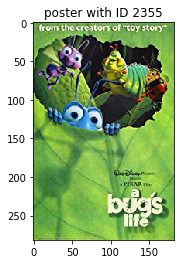

In [18]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

# 使用海报图像和不使用海报图像的文件路径不同，处理方式相同
use_poster = True
if use_poster:
    rating_path = "./work/ml-1m/new_rating.txt"
else:
    rating_path = "./work/ml-1m/ratings.dat"
    
with open(rating_path, 'r') as f:
    data = f.readlines()
    
# 从新的rating文件中收集所有的电影ID
mov_id_collect = []
for item in data:
    item = item.strip().split("::")
    usr_id,movie_id,score = item[0],item[1],item[2]
    mov_id_collect.append(movie_id)

# 根据电影ID读取图像
poster_path = "./work/ml-1m/posters/"

# 显示mov_id_collect中第几个电影ID的图像
idx = 1

poster = Image.open(poster_path+'mov_id{}.jpg'.format(str(mov_id_collect[idx])))
# poster = poster.resize([64, 64])
plt.figure("Image") # 图像窗口名称
plt.imshow(poster)
plt.axis('on') # 关掉坐标轴为 off
plt.title("poster with ID {}".format(mov_id_collect[idx])) # 图像题目
plt.show()

# 构建数据读取器

至此我们已经分别处理了用户、电影和评分数据，接下来我们要利用这些处理好的数据，构建一个数据读取器，方便在训练神经网络时直接调用。

首先，构造一个函数，把读取并处理后的数据整合到一起，即在rating数据中补齐用户和电影的所有特征字段。

In [15]:
def get_dataset(usr_info, rating_info, movie_info):
    trainset = []
    # 按照评分数据的key值索引数据
    for usr_id in rating_info.keys():
        usr_ratings = rating_info[usr_id]
        for movie_id in usr_ratings:
            trainset.append({'usr_info': usr_info[usr_id],
                             'mov_info': movie_info[movie_id],
                             'scores': usr_ratings[movie_id]})
    return trainset

dataset = get_dataset(usr_info, rating_info, movie_info)
print("数据集总数据数：", len(dataset))


数据集总数据数： 1000209


接下来构建数据读取器函数load_data()，先看一下整体结构：

In [16]:
import random
def load_data(dataset=None, mode='train'):
    
    """定义一些超参数等等"""
    
    # 定义数据迭代加载器
    def data_generator():
        
        """ 定义数据的处理过程"""
        
        data  = None
        yield data
        
    # 返回数据迭代加载器
    return data_generator
        

我们来看一下完整的数据读取器函数实现，核心是将多个样本数据合并到一个列表（batch），当该列表达到batchsize后，以yield的方式返回（Python数据迭代器）。

在进行批次数据拼合的同时，完成数据格式和数据尺寸的转换：

* 由于飞桨框架的网络接入层要求将数据先转换成np.array的类型，再转换成框架内置变量tensor的类型。所以在数据返回前，需将所有数据均转换成np.array的类型，方便后续处理。
* 每个特征字段的尺寸也需要根据网络输入层的设计进行调整。根据之前的分析，用户和电影的所有原始特征可以分为四类，ID类（用户ID，电影ID，性别，年龄，职业）、列表类（电影类别）、文本类（电影名称）和图像类（电影海报）。因为每种特征后续接入的网络层方案不同，所以要求他们的数据尺寸也不同。这里我们先初步的了解即可，待后续阅读了模型设计章节后，将对输入输出尺寸有更好的理解。

数据尺寸的说明：
1. ID类（用户ID，电影ID，性别，年龄，职业）处理成（256）的尺寸，以便后续接入Embedding层，数值256是batchsize。
2. 列表类（电影类别）处理成（256,6）的尺寸，数值6是电影最多的类别个数，以便后续接入全连接层。
3. 文本类（电影名称）处理成（256,1,15）的尺寸，15是电影名称的最多单词数，以便接入2D卷积层。2D卷积层要求输入数据为四维，对应到图像处理的场景，各个维度的含义是【批次大小，通道数、图像的长、图像的宽】，其中RGB的彩色图像是3通道，灰度图像是单通道。在此处理文本的场景，我们使用2D卷积层需要将输入处理成其所需要的维度数量。因为embedding函数会在输入Tensor shape的最后一维后面添加embedding_dim的维度做为输出的Shape，即当输入为（256,1,15），嵌入向量大小为32时，embedding函数会输出（256,1,15,32），这正好是2D卷积层所需要维度数量。
4. 图像类（电影海报）处理成（256,3,64,64）的尺寸， 以便接入2D卷积层。图像的原始尺寸是180\*270彩色图像，使用resize函数压缩成64\*64的尺寸，减少网络计算。

In [17]:
import random
use_poster = False
def load_data(dataset=None, mode='train'):
    
    # 定义数据迭代Batch大小
    BATCHSIZE = 256

    data_length = len(dataset)
    index_list = list(range(data_length))
    # 定义数据迭代加载器
    def data_generator():
        # 训练模式下，打乱训练数据
        if mode == 'train':
            random.shuffle(index_list)
        # 声明每个特征的列表
        usr_id_list,usr_gender_list,usr_age_list,usr_job_list = [], [], [], []
        mov_id_list,mov_tit_list,mov_cat_list,mov_poster_list = [], [], [], []
        score_list = []
        # 索引遍历输入数据集
        for idx, i in enumerate(index_list):
            # 获得特征数据保存到对应特征列表中
            usr_id_list.append(dataset[i]['usr_info']['usr_id'])
            usr_gender_list.append(dataset[i]['usr_info']['gender'])
            usr_age_list.append(dataset[i]['usr_info']['age'])
            usr_job_list.append(dataset[i]['usr_info']['job'])

            mov_id_list.append(dataset[i]['mov_info']['mov_id'])
            mov_tit_list.append(dataset[i]['mov_info']['title'])
            mov_cat_list.append(dataset[i]['mov_info']['category'])
            mov_id = dataset[i]['mov_info']['mov_id']

            if use_poster:
                # 不使用图像特征时，不读取图像数据，加快数据读取速度
                poster = Image.open(poster_path+'mov_id{}.jpg'.format(str(mov_id)))
                poster = poster.resize([64, 64])
                if len(poster.size) <= 2:
                    poster = poster.convert("RGB")

                mov_poster_list.append(np.array(poster))

            score_list.append(int(dataset[i]['scores']))
            # 如果读取的数据量达到当前的batch大小，就返回当前批次
            if len(usr_id_list)==BATCHSIZE:
                # 转换列表数据为数组形式，reshape到固定形状
                usr_id_arr = np.array(usr_id_list)
                usr_gender_arr = np.array(usr_gender_list)
                usr_age_arr = np.array(usr_age_list)
                usr_job_arr = np.array(usr_job_list)

                mov_id_arr = np.array(mov_id_list)

                mov_cat_arr = np.reshape(np.array(mov_cat_list), [BATCHSIZE, 6]).astype(np.int64)
                mov_tit_arr = np.reshape(np.array(mov_tit_list), [BATCHSIZE, 1, 15]).astype(np.int64)

                if use_poster:
                    mov_poster_arr = np.reshape(np.array(mov_poster_list)/127.5 - 1, [BATCHSIZE, 3, 64, 64]).astype(np.float32)
                else:
                    mov_poster_arr = np.array([0.])
                    
                scores_arr = np.reshape(np.array(score_list), [-1, 1]).astype(np.float32)
                
                # 返回当前批次数据
                yield [usr_id_arr, usr_gender_arr, usr_age_arr, usr_job_arr], \
                       [mov_id_arr, mov_cat_arr, mov_tit_arr, mov_poster_arr], scores_arr
                
                # 清空数据
                usr_id_list, usr_gender_list, usr_age_list, usr_job_list = [], [], [], []
                mov_id_list, mov_tit_list, mov_cat_list, score_list = [], [], [], []
                mov_poster_list = []
    return data_generator

load_data()函数通过输入的数据集，处理数据并返回一个数据迭代器。

我们将数据集按照8:2的比例划分训练集和验证集，可以分别得到训练数据迭代器和验证数据迭代器。

In [18]:
dataset = get_dataset(usr_info, rating_info, movie_info)
print("数据集总数量：", len(dataset))

trainset = dataset[:int(0.8*len(dataset))]
train_loader = load_data(trainset, mode="train")
print("训练集数量：", len(trainset))

validset = dataset[int(0.8*len(dataset)):]
valid_loader = load_data(validset, mode='valid')
print("验证集数量:", len(validset))

数据集总数量： 1000209
训练集数量： 800167
验证集数量: 200042


数据迭代器的使用方式如下：

In [19]:
for idx, data in enumerate(train_loader()):
    usr_data, mov_data, score = data
    
    usr_id_arr, usr_gender_arr, usr_age_arr, usr_job_arr = usr_data
    mov_id_arr, mov_cat_arr, mov_tit_arr, mov_poster_arr = mov_data
    print("用户ID数据尺寸", usr_id_arr.shape)
    print("电影ID数据尺寸", mov_id_arr.shape, ", 电影类别genres数据的尺寸", mov_cat_arr.shape, ", 电影名字title的尺寸", mov_tit_arr.shape)
    break

用户ID数据尺寸 (256,)
电影ID数据尺寸 (256,) , 电影类别genres数据的尺寸 (256, 6) , 电影名字title的尺寸 (256, 1, 15)


# 数据处理完整代码

到这里，我们已完成了ml-1m数据读取和处理，接下来，我们将数据处理的代码封装到一个Python类中，完整实现如下：

In [20]:
import random
import numpy as np
from PIL import Image

class MovieLen(object):
    def __init__(self, use_poster):
        self.use_poster = use_poster
        # 声明每个数据文件的路径
        usr_info_path = "./work/ml-1m/users.dat"
        if use_poster:
            rating_path = "./work/ml-1m/new_rating.txt"
        else:
            rating_path = "./work/ml-1m/ratings.dat"

        movie_info_path = "./work/ml-1m/movies.dat"
        self.poster_path = "./work/ml-1m/posters/"
        # 得到电影数据
        self.movie_info, self.movie_cat, self.movie_title = self.get_movie_info(movie_info_path)
        # 记录电影的最大ID
        self.max_mov_cat = np.max([self.movie_cat[k] for k in self.movie_cat])
        self.max_mov_tit = np.max([self.movie_title[k] for k in self.movie_title])
        self.max_mov_id = np.max(list(map(int, self.movie_info.keys())))
        # 记录用户数据的最大ID
        self.max_usr_id = 0
        self.max_usr_age = 0
        self.max_usr_job = 0
        # 得到用户数据
        self.usr_info = self.get_usr_info(usr_info_path)
        # 得到评分数据
        self.rating_info = self.get_rating_info(rating_path)
        # 构建数据集 
        self.dataset = self.get_dataset(usr_info=self.usr_info,
                                        rating_info=self.rating_info,
                                        movie_info=self.movie_info)
        # 划分数据集，获得数据加载器
        self.train_dataset = self.dataset[:int(len(self.dataset)*0.9)]
        self.valid_dataset = self.dataset[int(len(self.dataset)*0.9):]
        print("##Total dataset instances: ", len(self.dataset))
        print("##MovieLens dataset information: \nusr num: {}\n"
              "movies num: {}".format(len(self.usr_info),len(self.movie_info)))
    # 得到电影数据
    def get_movie_info(self, path):
        # 打开文件，编码方式选择ISO-8859-1，读取所有数据到data中 
        with open(path, 'r', encoding="ISO-8859-1") as f:
            data = f.readlines()
        # 建立三个字典，分别用户存放电影所有信息，电影的名字信息、类别信息
        movie_info, movie_titles, movie_cat = {}, {}, {}
        # 对电影名字、类别中不同的单词计数
        t_count, c_count = 1, 1

        count_tit = {}
        # 按行读取数据并处理
        for item in data:
            item = item.strip().split("::")
            v_id = item[0]
            v_title = item[1][:-7]
            cats = item[2].split('|')
            v_year = item[1][-5:-1]

            titles = v_title.split()
            # 统计电影名字的单词，并给每个单词一个序号，放在movie_titles中
            for t in titles:
                if t not in movie_titles:
                    movie_titles[t] = t_count
                    t_count += 1
            # 统计电影类别单词，并给每个单词一个序号，放在movie_cat中
            for cat in cats:
                if cat not in movie_cat:
                    movie_cat[cat] = c_count
                    c_count += 1
            # 补0使电影名称对应的列表长度为15
            v_tit = [movie_titles[k] for k in titles]
            while len(v_tit)<15:
                v_tit.append(0)
            # 补0使电影种类对应的列表长度为6
            v_cat = [movie_cat[k] for k in cats]
            while len(v_cat)<6:
                v_cat.append(0)
            # 保存电影数据到movie_info中
            movie_info[v_id] = {'mov_id': int(v_id),
                                'title': v_tit,
                                'category': v_cat,
                                'years': int(v_year)}
        return movie_info, movie_cat, movie_titles

    def get_usr_info(self, path):
        # 性别转换函数，M-0， F-1
        def gender2num(gender):
            return 1 if gender == 'F' else 0

        # 打开文件，读取所有行到data中
        with open(path, 'r') as f:
            data = f.readlines()
        # 建立用户信息的字典
        use_info = {}

        max_usr_id = 0
        #按行索引数据
        for item in data:
            # 去除每一行中和数据无关的部分
            item = item.strip().split("::")
            usr_id = item[0]
            # 将字符数据转成数字并保存在字典中
            use_info[usr_id] = {'usr_id': int(usr_id),
                                'gender': gender2num(item[1]),
                                'age': int(item[2]),
                                'job': int(item[3])}
            self.max_usr_id = max(self.max_usr_id, int(usr_id))
            self.max_usr_age = max(self.max_usr_age, int(item[2]))
            self.max_usr_job = max(self.max_usr_job, int(item[3]))
        return use_info
    # 得到评分数据
    def get_rating_info(self, path):
        # 读取文件里的数据
        with open(path, 'r') as f:
            data = f.readlines()
        # 将数据保存在字典中并返回
        rating_info = {}
        for item in data:
            item = item.strip().split("::")
            usr_id,movie_id,score = item[0],item[1],item[2]
            if usr_id not in rating_info.keys():
                rating_info[usr_id] = {movie_id:float(score)}
            else:
                rating_info[usr_id][movie_id] = float(score)
        return rating_info
    # 构建数据集
    def get_dataset(self, usr_info, rating_info, movie_info):
        trainset = []
        for usr_id in rating_info.keys():
            usr_ratings = rating_info[usr_id]
            for movie_id in usr_ratings:
                trainset.append({'usr_info': usr_info[usr_id],
                                 'mov_info': movie_info[movie_id],
                                 'scores': usr_ratings[movie_id]})
        return trainset
    
    def load_data(self, dataset=None, mode='train'):
        use_poster = False

        # 定义数据迭代Batch大小
        BATCHSIZE = 256

        data_length = len(dataset)
        index_list = list(range(data_length))
        # 定义数据迭代加载器
        def data_generator():
            # 训练模式下，打乱训练数据
            if mode == 'train':
                random.shuffle(index_list)
            # 声明每个特征的列表
            usr_id_list,usr_gender_list,usr_age_list,usr_job_list = [], [], [], []
            mov_id_list,mov_tit_list,mov_cat_list,mov_poster_list = [], [], [], []
            score_list = []
            # 索引遍历输入数据集
            for idx, i in enumerate(index_list):
                # 获得特征数据保存到对应特征列表中
                usr_id_list.append(dataset[i]['usr_info']['usr_id'])
                usr_gender_list.append(dataset[i]['usr_info']['gender'])
                usr_age_list.append(dataset[i]['usr_info']['age'])
                usr_job_list.append(dataset[i]['usr_info']['job'])

                mov_id_list.append(dataset[i]['mov_info']['mov_id'])
                mov_tit_list.append(dataset[i]['mov_info']['title'])
                mov_cat_list.append(dataset[i]['mov_info']['category'])
                mov_id = dataset[i]['mov_info']['mov_id']

                if use_poster:
                    # 不使用图像特征时，不读取图像数据，加快数据读取速度
                    poster = Image.open(self.poster_path+'mov_id{}.jpg'.format(str(mov_id[0])))
                    poster = poster.resize([64, 64])
                    if len(poster.size) <= 2:
                        poster = poster.convert("RGB")

                    mov_poster_list.append(np.array(poster))

                score_list.append(int(dataset[i]['scores']))
                # 如果读取的数据量达到当前的batch大小，就返回当前批次
                if len(usr_id_list)==BATCHSIZE:
                    # 转换列表数据为数组形式，reshape到固定形状
                    usr_id_arr = np.array(usr_id_list)
                    usr_gender_arr = np.array(usr_gender_list)
                    usr_age_arr = np.array(usr_age_list)
                    usr_job_arr = np.array(usr_job_list)

                    mov_id_arr = np.array(mov_id_list)
                    mov_cat_arr = np.reshape(np.array(mov_cat_list), [BATCHSIZE, 6]).astype(np.int64)
                    mov_tit_arr = np.reshape(np.array(mov_tit_list), [BATCHSIZE, 1, 15]).astype(np.int64)

                    if use_poster:
                        mov_poster_arr = np.reshape(np.array(mov_poster_list)/127.5 - 1, [BATCHSIZE, 3, 64, 64]).astype(np.float32)
                    else:
                        mov_poster_arr = np.array([0.])

                    scores_arr = np.reshape(np.array(score_list), [-1, 1]).astype(np.float32)

                    # 放回当前批次数据
                    yield [usr_id_arr, usr_gender_arr, usr_age_arr, usr_job_arr], \
                           [mov_id_arr, mov_cat_arr, mov_tit_arr, mov_poster_arr], scores_arr

                    # 清空数据
                    usr_id_list, usr_gender_list, usr_age_list, usr_job_list = [], [], [], []
                    mov_id_list, mov_tit_list, mov_cat_list, score_list = [], [], [], []
                    mov_poster_list = []
        return data_generator

# 声明数据读取类
dataset = MovieLen(False)
# 定义数据读取器
train_loader = dataset.load_data(dataset=dataset.train_dataset, mode='train')
# 迭代的读取数据， Batchsize = 256
for idx, data in enumerate(train_loader()):
    usr, mov, score = data
    print("打印用户ID，性别，年龄，职业数据的维度：")
    for v in usr:
        print(v.shape)
    print("打印电影ID，名字，类别数据的维度：")
    for v in mov:
        print(v.shape)
    
    break
    


##Total dataset instances:  1000209
##MovieLens dataset information: 
usr num: 6040
movies num: 3883
打印用户ID，性别，年龄，职业数据的维度：
(256,)
(256,)
(256,)
(256,)
打印电影ID，名字，类别数据的维度：
(256,)
(256, 6)
(256, 1, 15)
(1,)


# 总结

本节主要介绍了电影推荐数据集ml-1m，并对数据集中的用户数据、电影数据、评分数据进行介绍和处理，将字符串形式的数据转成了数字表示的数据形式，并构建了数据读取器，最终将数据处理和数据读取封装到一个Python类中，如下图所示：
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/f68016caa41e412e8b78d99568eb254898f2652d897f4e94bb3da60c54e62b39" width="500" ></center>

<center><br>图4：数据处理流程图 </br></center>

各数据处理前后格式如下：

| 数据分类 | 输入数据样例 | 输出数据样例 |
| -------- | -------- | -------- |
| **用户数据**     | UserID::Gender::Age::Occupation <br>1::F::1::10     | {'usr_id': 1, 'gender': 1, 'age': 1, 'job': 10}    |
| **电影数据**     | MovieID::Title::Genres <br>2::Jumanji (1995)::Adventure\|Children's\|Fantasy     | {'mov_id': 2, 'title': [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'category': [4, 2, 5, 0, 0, 0]}     |
| **评分数据**     | UserID::MovieID::Rating <br>1::1193::5    | {'usr_id': 1, 'mov_id': 1193, 'score': 5}|
| **海报数据**     | "mov_id" + MovieID+".jpg"格式的图片    | 64\*64\*3的像素矩阵|

虽然我们将文本的数据转换成了数字表示形式，但是这些数据依然是离散的，不适合直接输入到神经网络中，还需要对其进行Embedding操作，将其映射为固定长度的向量。

接下来我们开始个性化电影推荐的第二个部分：模型设计。